# Tutorial: Learning to reconstruct data based on context information

## Contents of Tutorial

This tutorial demonstrates how to use the mmcontext package to construct and train a deep learning network which takes AnnData objects and learns joint representations of context and data information. Here we focus on reconstructing experimental data from the modified context embeddings. The learning objective includes contrastive learning which allows the model learn the realtionship between context and data. The trained model can then be used to predict data for novel contexts.

We'll walk through the steps of:

**Preprocessing**:
1. Loading the Dataset
2. Generating Embeddings
3. Normalizing Embeddings
4. Aligning Embeddings
5. Constructing the Dataset
6. Creating a Data Loader

**Model fitting**:
1. Initialize the model
2. Configure the loss
3. Train the model

**Evaluation**
1. Visual evaluation of reconstruction quality
2. scib based metrics on data and embedding space
3. Data properties of orignal and reconstructed data

In [213]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing
#### 1. Loading the Dataset

The input data has to be an {class}`anndata.AnnData` object. First, we'll load the example dataset provided in data/small_cellxgene.h5ad. It is derived from the cellxgene census {cite:p}`czi2023cz` and contains cells of various tissues and celltypes from different studys. It is a custom made dataset that contains data from various tissues originating from different datasets. The scvi embedding included is provided by cellxgene and contains embeddings computed with the scvi variational autoencoder trained on the cellxgene corpus. 

In [2]:
# Import necessary libraries
import anndata
import scanpy as sc

data_path = "../../data/raw/large_cellxgene.h5ad"
# Load the dataset
adata = anndata.read_h5ad(data_path)
# Display basic information about the dataset
print(adata)

AnnData object with n_obs × n_vars = 280000 × 5000
    obs: 'soma_joinid', 'donor_id', 'disease', 'sex', 'dataset_id', 'cell_type', 'assay', 'tissue', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scvi'


In [3]:
# Log transformation for reconstruction
sc.pp.log1p(adata)

In [4]:
import numpy as np
from pathlib import Path

# subset 20000 cells from the dataset and save both the remaining and the removed cells
n_test = 20000
test_path = "../../data/raw/test/"
train_path = "../../data/raw/train/"
# Create random index for test cells
random_indices = np.random.choice(adata.n_obs, size=n_test, replace=False)

# Create boolean mask and slice the original AnnData
test_mask = np.zeros(adata.n_obs, dtype=bool)
test_mask[random_indices] = True

test_adata = adata[test_mask].copy()
train_adata = adata[~test_mask].copy()
# Ensure output directories exist
Path(test_path).mkdir(parents=True, exist_ok=True)
Path(train_path).mkdir(parents=True, exist_ok=True)

# Write subsets to disk
test_file_path = Path(test_path) / "adata_test.h5ad"
train_file_path = Path(train_path) / "adata_train.h5ad"

test_adata.write(test_file_path)
train_adata.write(train_file_path)

In [5]:
from mmcontext.pp.utils import remove_entries, consolidate_low_frequency_categories

# split anndata into train and test
# train_adata, test_adata = split_anndata(adata, train_size=0.8)
remove_entries(train_adata)
remove_entries(test_adata)
# remove cells and datasets with less than 5 appearances
train_adata = consolidate_low_frequency_categories(
    train_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)
# remove cells and datasets with less than 5 appearances
test_adata = consolidate_low_frequency_categories(
    test_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)

mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext.pp.utils - INFO - No cells with zero variance found.
mmcontext.pp.utils - INFO - No cells with zero variance found.


#### 2. Generate Embeddings

We will generate context embeddings based on the categorical metadata fields cell_type and tissue using the {class}`mmcontext.pp.CategoryEmbedder` class.
The method is based on creating an embedding of the individual categories of a cell with a text model. The `embeddings_file_path` points to a dictionary that contains embeddings for a range of cell types and tissues from the cellxgene corpus, thereby allowing the method to work without needing an API call. Only if some categories are not found in the dictionary the api will be used. If only a few are unknown, these will just be filled with a zero embedding. The `unkown_threshold` parameter controls how many new categories are needed to use the API. For that of course an API Key will be needed, which has to be set as an environmental variable "OPENAI_API_KEY". 

We will use the precomputed data embeddings stored in `adata.obsm['scvi']` as our data embeddings

In [6]:
# Import the CategoryEmbedder class
from mmcontext.pp import CategoryEmbedder, Embedder, AnnDataStoredEmbedder

# Specify the categories to embed
categories = ["cell_type"]
one_hot = False
# Initialize the CategoryEmbedder
category_embedder = CategoryEmbedder(
    metadata_categories=categories,
    model="text-embedding-3-small",
    combination_method="concatenate",
    embeddings_file_path="../../data/emb_dicts/category_embeddings_text-embedding-3-small_metadata_embeddings.pkl.gz",
    one_hot=one_hot,
)
data_embedder = AnnDataStoredEmbedder(obsm_key="scvi")
# Initialize the Embedder without embedders
embedder = Embedder(context_embedder=category_embedder, data_embedder=data_embedder)

# Create embeddings using external embeddings
for adata in [train_adata, test_adata]:
    embedder.create_embeddings(adata)
    # Confirm the shape of the context embeddings
    print("Context Embeddings Shape:", adata.obsm["c_emb"].shape)
    print("Data Embeddings Shape:", adata.obsm["d_emb"].shape)

mmcontext.pp.context_embedder - INFO - Loaded embeddings from file.
mmcontext.pp.context_embedder - INFO - Embeddings dictionary contains the following categories: dict_keys(['cell_type', 'tissue', 'assay']) with a total of 947 elements.
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings Shape: (259879, 1536)
Data Embeddings Shape: (259879, 50)
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddi

#### 3. Normalize Embeddings 

Now that the embeddings are created and stored in the adata object we can apply normalization. We will use the {class}`mmcontext.pp.MinMaxNormalizer` here. 

In [7]:
# Import the MinMaxNormalizer class
from mmcontext.pp import MinMaxNormalizer

# Initialize the MinMaxNormalizer
normalizer = MinMaxNormalizer()
# Normalize the embeddings
for adata in [train_adata, test_adata]:
    normalizer.normalize(adata)

    # Confirm that normalized embeddings are stored
    print("Normalized Data Embeddings Shape:", adata.obsm["d_emb_norm"].shape)
    print("Normalized Context Embeddings Shape:", adata.obsm["c_emb_norm"].shape)

mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (259879, 50)
Normalized Context Embeddings Shape: (259879, 1536)
mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (19839, 50)
Normalized Context Embeddings Shape: (19839, 1536)


#### 4. Aligning Embeddings

After normalization we will now use a {class}`mmcontext.pp.DimAligner` to make sure the dimensions of both data and context embeddings are equal, as this will be nescessary for the model. We will use the {class}`mmcontext.pp.PCAReducer` for this. If embeddings are larger than target latent dimension, they will be reduced via PCA. If there are smaller, padding with zeros will be applied. If using the {class}`mmcontext.pp.PCAReducer`, you can evaluate the principal components with some plots and metrics.

In [8]:
from omegaconf import DictConfig

# Create a DictConfig object for the configuration
config = DictConfig(
    {
        "evaluate_pca": True,
        "save_path": "pca_eval_oh",
        "scree_plot": True,
        "cumulative_variance_plot": True,
        "loadings_heatmap": True,
        "loadings_heatmap_options": {
            "threshold": 0,  # Only include loadings above this threshold
            "top_n_components": 64,  # Number of principal components to include in the heatmap
            "top_n_variables": 1000,  # Number of variables to display in the heatmap
        },
    }
)
# Configuration dictionary for PCA evaluation

if config.evaluate_pca and one_hot:
    config.one_hot_order = adata.uns["one_hot_order"]

In [9]:
# Import the PCAReducer class
from mmcontext.pp import PCAReducer

# Initialize the PCAReducer with the desired latent dimension
latent_dim = 64
aligner = PCAReducer(latent_dim=latent_dim, config=config)

# Align the embeddings
for adata in [train_adata, test_adata]:
    aligner.align(adata)

    # Confirm that aligned embeddings are stored
    print("Aligned Data Embeddings Shape:", adata.obsm["d_emb_aligned"].shape)
    print("Aligned Context Embeddings Shape:", adata.obsm["c_emb_aligned"].shape)

mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh/loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (259879, 64)
Aligned Context Embeddings Shape: (259879, 64)
mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh/loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (19839, 64)
Aligned Context Embeddings Shape: (19839, 64)


#### 5. Constructing the Dataset

Finally, we will construct a dataset using the aligned embeddings, suitable for training models with PyTorch.

In [41]:
# Import the DataSetConstructor class
from mmcontext.pp import DataSetConstructor

# The sequence length for the dataset. Since attention mechanisms will be used, samples can be grouped into sequences to perform attention within the sequence.
seq_length = 64
batch_size = 32
# Initialize the DataSetConstructor
train_dataset_constructor = DataSetConstructor(
    out_emb_keys={"data_embedding": "d_emb", "context_embedding": "c_emb"},
    use_raw=True,
    chunk_size=seq_length * batch_size,
    batch_size=batch_size,
)
test_dataset_constructor = DataSetConstructor(
    out_emb_keys={"data_embedding": "d_emb", "context_embedding": "c_emb"},
    use_raw=True,
    chunk_size=seq_length * batch_size,
    batch_size=batch_size,
)

# Add the AnnData object to the dataset
train_dataset_constructor.add_anndata(
    train_adata,
    emb_keys={"data_embedding": "d_emb_aligned", "context_embedding": "c_emb_aligned"},
    sample_id_key="soma_joinid",
)
test_dataset_constructor.add_anndata(
    test_adata,
    emb_keys={"data_embedding": "d_emb_aligned", "context_embedding": "c_emb_aligned"},
    sample_id_key="soma_joinid",
)


# Construct the dataset
train_dataset = train_dataset_constructor.construct_dataset(seq_length=seq_length)
test_dataset = test_dataset_constructor.construct_dataset(seq_length=seq_length)

#### 6. Create a Dataloader
Create a pyTorch Dataloader which can be iterated over

In [42]:
from torch.utils.data import DataLoader

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
# For now use the test data as validation data
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Iterate over DataLoader and verify batch shapes
for batch in train_loader:
    data_embeddings = batch["d_emb"]  # Shape: (batch_size, seq_length, embedding_dim)
    context_embeddings = batch["c_emb"]  # Shape: (batch_size, seq_length, embedding_dim)
    sample_ids = batch["sample_id"]  # Shape: (batch_size, seq_length)
    raw_data = batch["raw_data"]  # Shape: (batch_size, seq_length, num_features)

    print(data_embeddings.shape)
    print(context_embeddings.shape)
    print(sample_ids.shape)
    print(raw_data.shape)
    break  # Only need to check the first batch

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
torch.Size([32, 64, 64])
torch.Size([32, 64, 64])
torch.Size([32, 64])
torch.Size([32, 64, 5000])


### Model fitting
#### 1. Initializing the Model
The {class}`mmcontext.engine.MMContextEncoder` is the main encoder which will be used to create embeddings based on the available data and context embeddings. It's structure is flexible and is build upon torchs {class}`torch.nn.TransformerEncoder` which creates stacks of the {class}`mmcontext.engine.CustomTransformerEncoderLayer` which can be configured to be 

1. To apply self attention (use_self_attention = True)
2. To apply cross attention (use_cross_attention = True)
3. To use both self and cross attention (both True)
4. An MLP only model (both False)

The model takes two matrix inputs, `in_main` and `in_cross`. in_main will be passed through the MLP and optionally the self-attention layers, while in_cross is only used if cross-attention is used. In the end the model outputs embeddings of the same shape as in_main, updated based on the learning objective. The inputs are handled in the {class}`mmcontext.engine.Trainer` in dependancy with the settings used for the loss. 

In [43]:
from mmcontext.engine import MMContextEncoder, ZINBDecoder

hidden_dim = 64
num_layers = 1
num_heads = 1
encoder = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)
encoder2 = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)
decoder = ZINBDecoder(
    input_dim=latent_dim,
    hidden_dims=[64, 128],
    output_dim=train_adata.shape[1],  # number of genes
)

mmcontext.engine.models - INFO - MMContextEncoder initialized with embedding_dim = 64, num_layers = 1, use_self_attention = False, use_cross_attention = False.
ZINBDecoder
mmcontext.engine.models - INFO - ZINBDecoder initialized with input_dim = 64, hidden_dims = [64, 128], output_dim = 5000.


#### 2. Configure the loss
The loss function is a central part of this project. The loss is implemented to be extendable and customizable by having a {class}`mmcontext.engine.LossManager` which you can use to add different losses to and which will be passed to the {class}`mmcontext.engine.Trainer` to compute the total loss (as a weighted average of the components) during Training. The current main implementation of a {class}`mmcontext.engine.LossFunction` is the {class}`mmcontext.engine.ContrastiveLoss`, which is a custom approach to contrastive learning. It's main configuration parameters are `target_mode` and `current_mode` which refer to the way in which the target similarity matrix and the current (during model training) similarity matrix are constructed. For example if `target_mode = 'context_context'`, the original context embeddings are used to create the target similarity matrix. Therefore during training, the loss is calcualted as the mean squared error between the current similarity matrix and the one based on the context. If `current_mode = 'data_data'`, the model would learn to find representations of the data that represent similarity found in the respective context.  

In [44]:
from mmcontext.engine import LossManager, ContrastiveLoss, ZINBLoss

loss_manager = LossManager()
loss_manager.add_loss(ContrastiveLoss(target_mode="infoNCE", current_mode="data_context", similarity_metric="cosine"))
loss_manager.add_loss(ZINBLoss(), weight=0.01)

mmcontext.engine.losses - INFO - Adding loss function: ContrastiveLoss(target_mode=infoNCE, current_mode=data_context, similarity_metric=cosine) with weight 1.00
mmcontext.engine.losses - INFO - Adding loss function: ZINBLoss with weight 0.01


#### 3. Train the Model
The Trainer uses the defined model and loss the conduct training, aiming to iterativly minimize the loss. The {func}`mmcontext.engine.Trainer.fit` method can take a training and a validation dataloader as input. If a validation loader is given and a save_path is used, the weights of the best performing model can be saved to file. The {class}`mmcontext.engine.MMContextEncoder` has a method `load` to load weights from file.
Per default data embeddings are used for in_main while context embeddings are used as in_cross.

In [45]:
from mmcontext.engine import Trainer
import torch

model_parameters = list(encoder.parameters()) + list(decoder.parameters())
trainer = Trainer(
    encoders={"context_encoder": encoder},
    decoder=decoder,
    loss_manager=loss_manager,
    optimizer=torch.optim.Adam(model_parameters),
    encoder_inputs={
        "context_encoder": {"in_main": "c_emb"},
    },
    temperature=0.07,
)

mmcontext.engine.trainer - INFO - Running on device: mps


The {class}`mmcontext.eval.SystemMonitor` is used to track CPU and GPU usage as well as file reading/writing speed.

In [46]:
from mmcontext.eval.system_usage import SystemMonitor

monitor = SystemMonitor(interval=0.1)
monitor.start()

res = trainer.fit(train_loader, val_loader, epochs=50, save=True)

monitor.stop()

mmcontext.engine.trainer - INFO - Starting Epoch 1/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 66.8042, Time per sample: 21.90µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 50.3439, Time per sample: 21.98µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 32.4117, Time per sample: 21.90µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 15.1864, Time per sample: 21.83µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 15.0598, Time per sample: 21.89µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 18.6651, Time per sample: 21.98µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 15.6293, Time per sample: 21.89µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 17.5922, Time per sample: 21.85µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 12.6169, Time per sample: 21.90µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 24.0582, Time per sample: 21.79µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 19.8248
mmcontext.engine.trainer - INFO - Epoch 1/50 - Train Loss: 28.5083, Val Loss: 19.8248
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 2/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 20.9336, Time per sample: 21.33µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 19.4617, Time per sample: 21.77µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 20.6199, Time per sample: 21.61µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.3115, Time per sample: 21.65µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 14.3851, Time per sample: 21.57µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 17.1552, Time per sample: 21.67µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 14.9441, Time per sample: 21.72µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 16.7703, Time per sample: 21.66µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 12.6509, Time per sample: 21.37µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 23.0828, Time per sample: 21.58µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 19.2873
mmcontext.engine.trainer - INFO - Epoch 2/50 - Train Loss: 19.0407, Val Loss: 19.2873
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 3/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 20.3946, Time per sample: 23.13µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 19.1121, Time per sample: 22.38µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 20.2844, Time per sample: 21.85µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.2348, Time per sample: 22.36µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 13.9528, Time per sample: 21.80µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 16.8240, Time per sample: 21.72µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 14.7794, Time per sample: 21.61µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 15.8070, Time per sample: 21.70µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 12.1750, Time per sample: 21.92µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 21.6264, Time per sample: 21.93µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 19.0684
mmcontext.engine.trainer - INFO - Epoch 3/50 - Train Loss: 18.5268, Val Loss: 19.0684
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 4/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 20.2442, Time per sample: 21.42µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 18.8594, Time per sample: 21.33µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 20.0976, Time per sample: 21.46µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.1996, Time per sample: 21.65µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 13.3812, Time per sample: 21.55µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 16.2420, Time per sample: 21.44µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 14.6300, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 15.1657, Time per sample: 21.52µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.9845, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.7898, Time per sample: 21.46µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 19.0472
mmcontext.engine.trainer - INFO - Epoch 4/50 - Train Loss: 18.1453, Val Loss: 19.0472
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 5/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 20.1729, Time per sample: 21.46µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 18.5092, Time per sample: 21.32µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.9259, Time per sample: 21.26µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.2005, Time per sample: 21.41µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 13.1920, Time per sample: 21.59µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 16.1007, Time per sample: 21.51µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 14.4706, Time per sample: 21.55µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 15.1149, Time per sample: 21.89µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.9528, Time per sample: 21.88µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.4805, Time per sample: 21.75µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 19.0572
mmcontext.engine.trainer - INFO - Epoch 5/50 - Train Loss: 17.9710, Val Loss: 19.0572
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 6/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 20.0910, Time per sample: 21.44µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 18.1838, Time per sample: 21.53µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.7561, Time per sample: 21.38µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.3362, Time per sample: 21.46µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 13.1140, Time per sample: 21.62µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.8561, Time per sample: 21.59µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 14.2150, Time per sample: 21.71µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 15.1024, Time per sample: 21.55µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.9417, Time per sample: 21.71µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.4093, Time per sample: 22.39µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 19.0834
mmcontext.engine.trainer - INFO - Epoch 6/50 - Train Loss: 17.8533, Val Loss: 19.0834
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 7/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 20.0126, Time per sample: 21.46µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 17.8316, Time per sample: 21.28µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.5650, Time per sample: 21.40µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.4297, Time per sample: 21.65µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 13.0392, Time per sample: 21.43µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.7608, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 14.0797, Time per sample: 21.32µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 15.1457, Time per sample: 21.55µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.9564, Time per sample: 21.42µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.2887, Time per sample: 21.44µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 19.0549
mmcontext.engine.trainer - INFO - Epoch 7/50 - Train Loss: 17.7565, Val Loss: 19.0549
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 8/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.9452, Time per sample: 21.70µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 17.6061, Time per sample: 21.65µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.4331, Time per sample: 24.80µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.5602, Time per sample: 21.72µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.9721, Time per sample: 21.61µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.6486, Time per sample: 21.61µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.9503, Time per sample: 21.65µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 15.1136, Time per sample: 21.59µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.9380, Time per sample: 21.75µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.2813, Time per sample: 21.38µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 19.0141
mmcontext.engine.trainer - INFO - Epoch 8/50 - Train Loss: 17.6729, Val Loss: 19.0141
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 9/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.8641, Time per sample: 21.36µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 17.3506, Time per sample: 21.42µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.3298, Time per sample: 21.32µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.6711, Time per sample: 21.52µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.9031, Time per sample: 21.52µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.5974, Time per sample: 21.36µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.8809, Time per sample: 21.46µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 15.1179, Time per sample: 21.54µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.9324, Time per sample: 21.48µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.2596, Time per sample: 21.45µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9764
mmcontext.engine.trainer - INFO - Epoch 9/50 - Train Loss: 17.5960, Val Loss: 18.9764
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 10/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.8077, Time per sample: 21.59µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 17.1029, Time per sample: 21.19µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.2640, Time per sample: 21.46µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.7339, Time per sample: 21.49µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.8439, Time per sample: 21.37µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.6211, Time per sample: 21.36µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.8328, Time per sample: 21.71µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 15.0541, Time per sample: 21.57µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.9045, Time per sample: 21.69µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.2163, Time per sample: 22.03µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9331
mmcontext.engine.trainer - INFO - Epoch 10/50 - Train Loss: 17.5228, Val Loss: 18.9331
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 11/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.7222, Time per sample: 21.47µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 16.8473, Time per sample: 21.30µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.2003, Time per sample: 21.45µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.7410, Time per sample: 21.46µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.7844, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.5858, Time per sample: 21.34µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.7950, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.9874, Time per sample: 21.38µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.8764, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.1695, Time per sample: 21.29µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9065
mmcontext.engine.trainer - INFO - Epoch 11/50 - Train Loss: 17.4450, Val Loss: 18.9065
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 12/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.6767, Time per sample: 21.59µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 16.6319, Time per sample: 22.00µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.1443, Time per sample: 22.03µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.7076, Time per sample: 21.88µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.7292, Time per sample: 21.86µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.5714, Time per sample: 21.81µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.7620, Time per sample: 21.70µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.9179, Time per sample: 21.81µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.8515, Time per sample: 21.81µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.1322, Time per sample: 21.74µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.8950
mmcontext.engine.trainer - INFO - Epoch 12/50 - Train Loss: 17.3728, Val Loss: 18.8950
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 13/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.6251, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 16.4500, Time per sample: 21.69µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.1211, Time per sample: 21.75µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.6990, Time per sample: 21.97µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.6837, Time per sample: 21.79µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.5397, Time per sample: 22.24µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.7374, Time per sample: 21.87µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.8937, Time per sample: 22.01µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.8446, Time per sample: 21.98µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.1004, Time per sample: 22.30µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.8927
mmcontext.engine.trainer - INFO - Epoch 13/50 - Train Loss: 17.3520, Val Loss: 18.8927
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 14/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.5684, Time per sample: 21.80µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 16.2988, Time per sample: 21.84µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.1044, Time per sample: 21.67µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.6461, Time per sample: 21.65µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.6395, Time per sample: 21.64µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.5028, Time per sample: 21.79µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.7297, Time per sample: 22.04µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.8617, Time per sample: 21.97µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.8279, Time per sample: 22.03µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.0804, Time per sample: 21.87µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.8988
mmcontext.engine.trainer - INFO - Epoch 14/50 - Train Loss: 17.2555, Val Loss: 18.8988
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 15/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.5159, Time per sample: 21.47µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 16.1735, Time per sample: 21.53µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.0645, Time per sample: 21.49µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.6048, Time per sample: 21.56µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.5981, Time per sample: 21.52µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.4706, Time per sample: 21.50µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.7161, Time per sample: 21.57µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.8486, Time per sample: 21.55µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.8206, Time per sample: 21.69µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.0599, Time per sample: 21.59µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9026
mmcontext.engine.trainer - INFO - Epoch 15/50 - Train Loss: 17.2049, Val Loss: 18.9026
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 16/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.4542, Time per sample: 21.64µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 16.0706, Time per sample: 25.51µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.0561, Time per sample: 22.42µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.5634, Time per sample: 22.73µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.5542, Time per sample: 21.98µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.4429, Time per sample: 22.21µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.6987, Time per sample: 22.32µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.8274, Time per sample: 21.75µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.8092, Time per sample: 21.84µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.0492, Time per sample: 21.61µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9177
mmcontext.engine.trainer - INFO - Epoch 16/50 - Train Loss: 17.1571, Val Loss: 18.9177
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 17/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.3978, Time per sample: 21.68µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 15.9876, Time per sample: 21.51µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 19.0314, Time per sample: 21.61µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.5305, Time per sample: 21.68µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.5175, Time per sample: 21.63µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.4190, Time per sample: 21.44µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.6880, Time per sample: 21.77µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.8271, Time per sample: 21.86µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.8044, Time per sample: 21.47µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.0300, Time per sample: 21.79µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9296
mmcontext.engine.trainer - INFO - Epoch 17/50 - Train Loss: 17.1179, Val Loss: 18.9296
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 18/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.3360, Time per sample: 21.35µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 15.9215, Time per sample: 21.43µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 18.9924, Time per sample: 21.35µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.4880, Time per sample: 21.54µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.4839, Time per sample: 21.47µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.3900, Time per sample: 21.44µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.6809, Time per sample: 21.69µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.8176, Time per sample: 21.47µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.7957, Time per sample: 21.48µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.0195, Time per sample: 21.41µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9370
mmcontext.engine.trainer - INFO - Epoch 18/50 - Train Loss: 17.0773, Val Loss: 18.9370
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 19/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.2919, Time per sample: 21.32µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 15.8681, Time per sample: 21.42µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 18.9795, Time per sample: 21.26µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.4643, Time per sample: 21.29µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.4540, Time per sample: 21.48µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.3709, Time per sample: 21.36µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.6765, Time per sample: 21.81µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.7879, Time per sample: 21.80µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.7831, Time per sample: 21.73µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 20.0057, Time per sample: 21.73µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9509
mmcontext.engine.trainer - INFO - Epoch 19/50 - Train Loss: 17.0474, Val Loss: 18.9509
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 20/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.2587, Time per sample: 21.43µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 15.8254, Time per sample: 21.63µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 18.9374, Time per sample: 21.47µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.4491, Time per sample: 21.51µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.4271, Time per sample: 21.82µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.3415, Time per sample: 21.42µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.6804, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.7850, Time per sample: 21.59µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.7830, Time per sample: 21.43µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 19.9976, Time per sample: 21.67µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9562
mmcontext.engine.trainer - INFO - Epoch 20/50 - Train Loss: 17.0129, Val Loss: 18.9562
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 21/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.2263, Time per sample: 21.38µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 15.7872, Time per sample: 21.48µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 18.9291, Time per sample: 21.52µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.4446, Time per sample: 21.56µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.3996, Time per sample: 21.67µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.3294, Time per sample: 21.54µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.6663, Time per sample: 21.66µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.7661, Time per sample: 21.68µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.7768, Time per sample: 21.72µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 19.9868, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9736
mmcontext.engine.trainer - INFO - Epoch 21/50 - Train Loss: 16.9887, Val Loss: 18.9736
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 22/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.2028, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 15.7658, Time per sample: 21.61µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 18.8989, Time per sample: 21.44µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.4194, Time per sample: 21.49µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.3799, Time per sample: 21.52µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.3099, Time per sample: 21.65µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.6680, Time per sample: 21.54µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.7551, Time per sample: 21.72µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.7720, Time per sample: 21.66µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 19.9807, Time per sample: 21.68µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9847
mmcontext.engine.trainer - INFO - Epoch 22/50 - Train Loss: 16.9645, Val Loss: 18.9847
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 23/50


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Batch 10/127, Loss: 19.1802, Time per sample: 21.42µs
mmcontext.engine.trainer - INFO - Batch 20/127, Loss: 15.7367, Time per sample: 21.65µs
mmcontext.engine.trainer - INFO - Batch 30/127, Loss: 18.8736, Time per sample: 21.53µs
mmcontext.engine.trainer - INFO - Batch 40/127, Loss: 14.4154, Time per sample: 21.61µs
mmcontext.engine.trainer - INFO - Batch 50/127, Loss: 12.3619, Time per sample: 21.48µs
mmcontext.engine.trainer - INFO - Batch 60/127, Loss: 15.2976, Time per sample: 21.43µs
mmcontext.engine.trainer - INFO - Batch 70/127, Loss: 13.6638, Time per sample: 21.42µs
mmcontext.engine.trainer - INFO - Batch 80/127, Loss: 14.7535, Time per sample: 21.39µs
mmcontext.engine.trainer - INFO - Batch 90/127, Loss: 11.7725, Time per sample: 21.67µs
mmcontext.engine.trainer - INFO - Batch 100/127, Loss: 19.9688, Time per sample: 21.55µs
mmcontext.engine.trainer - INFO

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/pythonjsonlogger/jsonlogger.py:11: DeprecationWarning: pythonjsonlogger.jsonlogger has been moved to pythonjsonlogger.json
  warnings.warn(


mmcontext - INFO - mmcontext logging configured using the specified configuration file.
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 18.9781
mmcontext.engine.trainer - INFO - Epoch 23/50 - Train Loss: 16.9420, Val Loss: 18.9781
mmcontext.engine.trainer - INFO - Validation loss has not improved for 10 epochs. Stopping training.


In [17]:
monitor.print_summary()


System Resource Usage Summary:
Core Utilization (mean/max % per core): 80.06/83.75% on 16 cores
Memory Usage (mean/max GB): 0.94/1.01 GB
Total System Memory: 128.00 GB
Baseline Memory Usage: 34.68 GB
Disk Read Rate (mean/max MB/s): 0.02/0.19 MB/s
Disk Write Rate (mean/max MB/s): 3.11/15.54 MB/s
No supported GPU detected.
Number of Threads (mean/max): 42.00/42


In [47]:
monitor.plot_metrics()

ValueError: not enough values to unpack (expected 2, got 0)

In [49]:
# The fitted model can be used to create universial embeddings
encoder.load(file_path="best_encoder_weights/best_context_encoder_weights.pth")
decoder.load(file_path="best_decoder_weights/best_decoder_weights.pth")
trainer = Trainer(
    encoders={"context_encoder": encoder},
    decoder=decoder,
    encoder_inputs={
        "context_encoder": {"in_main": "c_emb"},
    },
    device=torch.device("cpu"),
)
trainer.infer_adata(
    test_adata,
    sample_id_key="soma_joinid",
    seq_length=seq_length,
    batch_size=batch_size,
    chunk_size=seq_length * batch_size,
    output_zarr_path="inferred_adata.zarr",
    n_recon=2,
)

mmcontext.engine.models - INFO - Loading model state dictionary from best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.models - INFO - Loading model state dictionary from best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Running on device: cpu


In [50]:
inferred_adata = anndata.read_zarr("inferred_adata.zarr")

In [161]:
inferred_adata.X.toarray()

array([[0.       , 3.637586 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 2.8903718, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 3.3672957, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.7917595, 0.6931472, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.0986123, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

### Evaluation
#### 1. Visual Evaluation of reconstruction quality
By clustering orignal and reconstructed data jointly, it can be analysed how closly the predicted data matches the actual data. The predictions are only based on context information and the pre-trained model. Both a umap and a clustered heatmap can be used to visualise this.

In [152]:
from mmcontext.eval.clustering import (
    combine_original_and_reconstructions,
    cluster_combined_adata,
)
from mmcontext.pl.plotting import plot_umap


# Suppose `inferred_adata` has .X for the original data and multiple .layers for reconstructed data
combined_adata = combine_original_and_reconstructions(inferred_adata, max_reconstructions=3)
# Make sure we have unique IDs
combined_adata.obs_names_make_unique()
combined_adata.var_names_make_unique()

combined_adata = cluster_combined_adata(combined_adata, clustering_method="leiden", resolution=1.0)

combined_adata_red = consolidate_low_frequency_categories(
    combined_adata, columns=["cell_type"], threshold=500, remove=True
)
plot_umap(combined_adata_red, color_key=["origin", "cell_type"])

mmcontext.eval.clustering - INFO - Combining original data with up to 3 reconstruction layers.
mmcontext.eval.clustering - INFO - Processing reconstruction layer: reconstructed1
mmcontext.eval.clustering - INFO - Processing reconstruction layer: reconstructed2
mmcontext.eval.clustering - INFO - Concatenating 3 AnnData objects.
mmcontext.eval.clustering - INFO - Combination complete. Returning combined AnnData with shape (47064, 5000).
mmcontext.eval.clustering - INFO - Clustering combined AnnData with 47064 cells.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


mmcontext.eval.clustering - INFO - Clustering complete. Found 54 clusters.


mmcontext.pl.plotting - INFO - Starting plot_cells_by_genes_heatmap.
mmcontext.pl.plotting - INFO - Selected 30 HVGs based on cells with origin == '0'.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


mmcontext.pl.plotting - INFO - Heatmap saved at clustered_heatmap.png


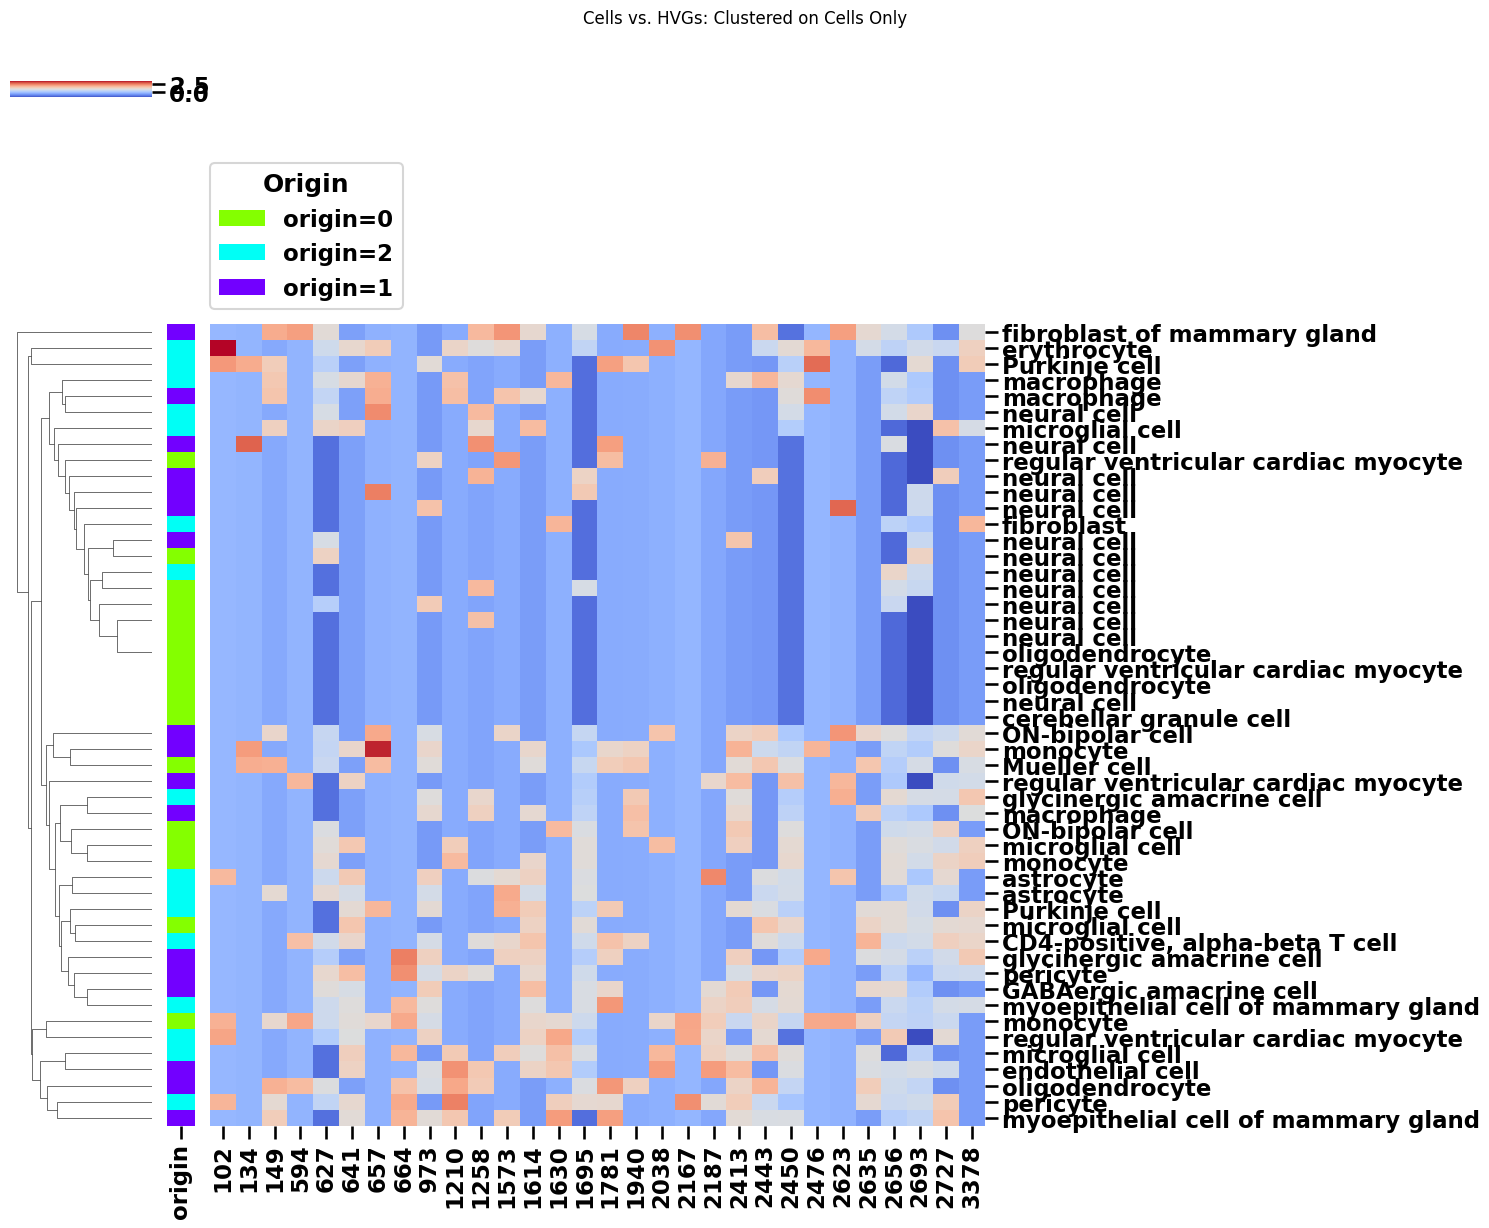

In [212]:
from mmcontext.pl.plotting import plot_clustered_heatmap
from mmcontext.eval.clustering import subsample_adata

# Optionally subsample for heatmap clarity
subsampled_adata = subsample_adata(combined_adata, subsample_size=50)
# Assuming `combined_adata_red` is your AnnData object after preprocessing
plot_clustered_heatmap(
    adata=subsampled_adata,
    num_hvgs=30,  # Select top 30 highly variable genes from original data
    clustering_method="leiden",
    resolution=1.0,
    figsize=(15, 12),
    cmap="coolwarm",
    show=True,
    save_path="clustered_heatmap.png",
)

We can also directly visualise the modified context embeddings which serve as input to the decoder when reconstructing data.

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='context_encoder_mod_emb'.


<Figure size 800x800 with 0 Axes>

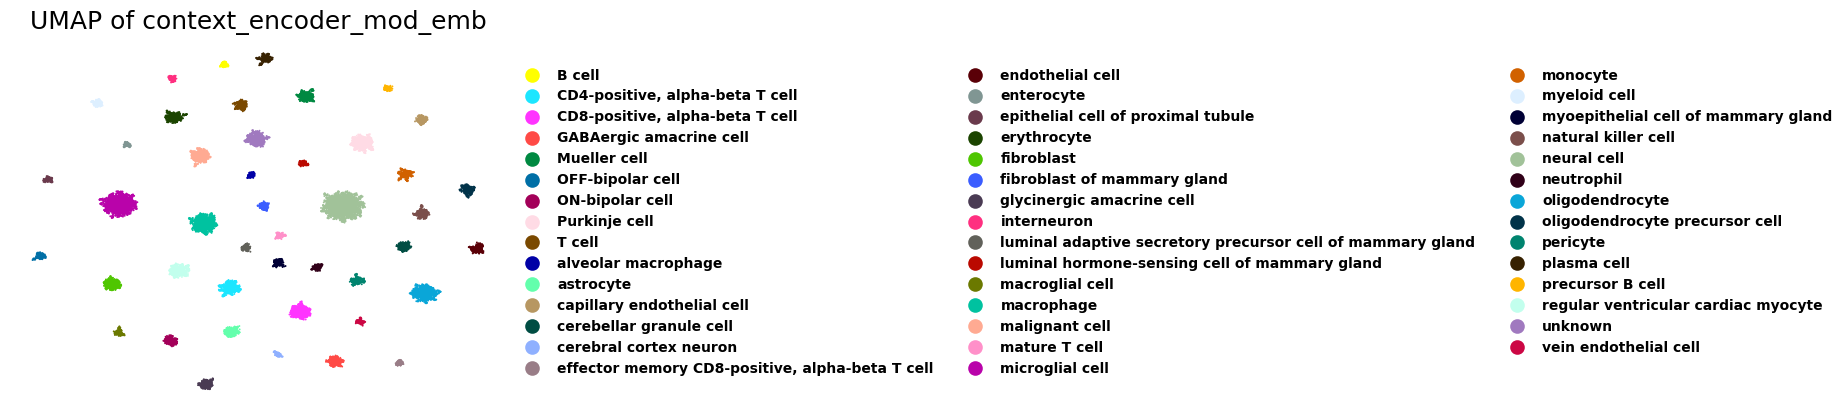

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [122]:
from mmcontext.pl import plot_umap

inferred_adata_red = consolidate_low_frequency_categories(
    inferred_adata, columns=["cell_type"], threshold=100, remove=True
)
# inferred_adata_red.obsm["recon"] = inferred_adata_red.layers["reconstructed1"]
plot_umap(inferred_adata_red, color_key="cell_type", embedding_key="context_encoder_mod_emb", save_plot=False)

#### 2. Evaluation with scib metrics
In order to assess the quality of the embeddings, the {class}`mmcontext.eval.scibEvaluator` can be used. It computes metrics from the scib package {cite:p}`luecken2022benchmarking` in order to asess bioconservation and batch integration.

In [123]:
from mmcontext.pl.plotting import plot_umap
from mmcontext.eval import scibEvaluator

# Initialize scibEvaluator
evaluator = scibEvaluator(
    adata=inferred_adata,
    batch_key="dataset_id",
    label_key="cell_type",
    embedding_key=["scvi", "context_encoder_mod_emb"],
    reconstructed_keys=list(inferred_adata.layers),
    max_cells=2000,  # subsample cells for faster computation
)

In [124]:
res = evaluator.evaluate()

mmcontext.eval.evaluate_scib - INFO - Computing metrics on raw data...
mmcontext.eval.evaluate_scib - INFO - Subsampling to 2000 cells for raw...
mmcontext.eval.evaluate_scib - INFO - Computing PCA on all genes...
Cluster for cluster_0.2 with leiden
resolution: 0.2, nmi: 0.5837422003374518
Cluster for cluster_0.4 with leiden
resolution: 0.4, nmi: 0.5973262380651712
Cluster for cluster_0.6 with leiden
resolution: 0.6, nmi: 0.6255260605758842
Cluster for cluster_0.8 with leiden
resolution: 0.8, nmi: 0.6329267566358945
Cluster for cluster_1.0 with leiden
resolution: 1.0, nmi: 0.6206719091425913
Cluster for cluster_1.2 with leiden
resolution: 1.2, nmi: 0.6286723653138676
Cluster for cluster_1.4 with leiden
resolution: 1.4, nmi: 0.6342547813761906
Cluster for cluster_1.6 with leiden
resolution: 1.6, nmi: 0.6375702683383434
Cluster for cluster_1.8 with leiden
resolution: 1.8, nmi: 0.6273763970807191
Cluster for cluster_2.0 with leiden
resolution: 2.0, nmi: 0.6287493174576342
optimised cluste

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Cluster for cluster_0.6 with leiden
resolution: 0.6, nmi: 0.9999999999999999
Cluster for cluster_0.8 with leiden
resolution: 0.8, nmi: 0.9999999999999999
Cluster for cluster_1.0 with leiden
resolution: 1.0, nmi: 0.9999999999999999
Cluster for cluster_1.2 with leiden
resolution: 1.2, nmi: 0.9999999999999999
Cluster for cluster_1.4 with leiden
resolution: 1.4, nmi: 0.9999999999999999
Cluster for cluster_1.6 with leiden
resolution: 1.6, nmi: 0.9999999999999999
Cluster for cluster_1.8 with leiden
resolution: 1.8, nmi: 0.9999999999999999
Cluster for cluster_2.0 with leiden
resolution: 2.0, nmi: 0.9999999999999999
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.9999999999999999
isolated labels: no more than 1 batches per label
isolated labels: ['GABAergic amacrine cell', 'Mueller cell', 'OFF-bipolar cell', 'ON-bipolar cell', 'Purkinje cell', 'cerebellar granule cell', 'cerebral cortex neuron', 'fibroblast of mammary gland', 'glycinergic amacrine cell',

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


GABAergic amacrine cell: 1.0
resolution: 0.2, max_f1: 1.0
Cluster for iso_label_0.4 with leiden
Mueller cell: 1.0
OFF-bipolar cell: 1.0
ON-bipolar cell: 1.0
Purkinje cell: 1.0
cerebellar granule cell: 1.0
cerebral cortex neuron: 1.0
fibroblast of mammary gland: 1.0
glycinergic amacrine cell: 0.9999999403953552
luminal adaptive secretory precursor cell of mammary gland: 1.0
luminal hormone-sensing cell of mammary gland: 1.0
resolution: 0.4, max_f1: 1.0
Cluster for iso_label_0.6 with leiden
macroglial cell: 1.0
mature T cell: 1.0
myoepithelial cell of mammary gland: 1.0
regular ventricular cardiac myocyte: 1.0
resolution: 0.6, max_f1: 1.0
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 1.0
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 1.0
Cluster for iso_label_1.2 with leiden
resolution: 1.2, max_f1: 1.0
Cluster for iso_label_1.4 with leiden
resolution: 1.4, max_f1: 1.0
Cluster for iso_label_1.6 with leiden
resolution: 1.6, max_f1: 1.0
Cluster for iso_labe

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/scib/knn_graph/knn_graph.o'
mean silhouette per group:                                                  silhouette_score
group                                                            
B cell                                                        1.0
CD4-positive, alpha-beta T cell                               1.0
CD8-positive, alpha-beta T cell                               1.0
T cell                                                        1.0
alveolar macrophage                                           1.0
astrocyte                                                     1.0
capillary endothelial cell                                    1.0
effector memory CD8-positive, alpha-beta T cell               1.0
endothelial cell                                              1.0
enterocy

In [125]:
from mmcontext.pl.plotting import plot_grouped_bar_chart

plot_grouped_bar_chart(res, save_plot=False)

,data_id,hvg,type,ARI,NMI,ASW,Isolated_Labels_ASW,Isolated_Labels_F1,Bio_Conservation_Score,Graph_Connectivity,Silhouette_Batch,Batch_Integration_Score,Overall_Score
0,,None,raw,0.354418,0.637570,0.410125,0.538921,0.422006,0.472608,0.828548,0.702436,0.765492,0.589762
1,,None,reconstructed1,0.442281,0.535276,0.503565,0.486934,0.304795,0.454570,0.657011,0.927124,0.792067,0.589569
2,,None,reconstructed2,0.444866,0.547602,0.507403,0.474455,0.224448,0.439755,0.655616,0.916437,0.786026,0.578263
3,,None,embedding_scvi,0.397875,0.705263,0.517042,0.559868,0.550763,0.546162,0.917241,0.789632,0.853436,0.669072
4,,None,embedding_context_encoder_mod_emb,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 3. Comparing Data Properties
We can also compare the reconstructed matrix and the original matrix. We do this by computing a variety of data properties and comparing them between orignal and reconstructed data. One can add further orignal and reconstructed datasets in the same manner. This is handy if you have a variety of test datasets.

In [90]:
# Initialize the DataProperties object
from mmcontext.eval import DataProperties

dp = DataProperties(predefined_subset="microbiome")

In [91]:
dp.add_original_data(test_adata.X.toarray())

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: An input array is constant; the correlation coefficient is not defined.
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide


In [92]:
# Add reconstructed data to DataProperties object
for reconstructed_data in inferred_adata.layers:
    dp.add_reconstructed_data(inferred_adata.layers[reconstructed_data])

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing LinCoefPoly2: Polyfit may be poorly conditioned
mmcontext.eval.data_properties - WARNING - Warning computing QuadCoefPoly2: Polyfit may be poorly conditioned
mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing LinCoefPoly2: Polyfit may be poorly conditioned
mmcontext.eval.data_properties - WARNING - Warning computing QuadCoefPoly2: Polyfit may be poorly conditioned


In [93]:
dp.compare_data_properties()

,id,recon_id,nSamples,LinCoefPoly2,maxColSums,bimodalityColCorr,sdColSums,sdp0Col,meanColSums,coefHclustRows,...,sdRowCorr,median,q95,sdRowMediansLog2cpm,QuadCoefPoly2,sdColCorr,coefHclustCols,sdRowMeansLog2cpm,corrColSumsP0Sample,meanLog2FC
0,0,0,0.0,2.813668,0.116398,NaN,0.444697,0.236523,0.590646,0.012476,...,0.886848,0.0,0.528766,1.719783e-07,-4.496366,0.209001,0.020414,1.115376,-0.005771,0.551292
1,0,1,0.0,2.813921,0.118004,NaN,0.445098,0.236091,0.591155,0.003892,...,0.821949,0.0,0.528766,1.719783e-07,-4.495562,0.204028,0.018411,1.116808,-0.005722,1.288239


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


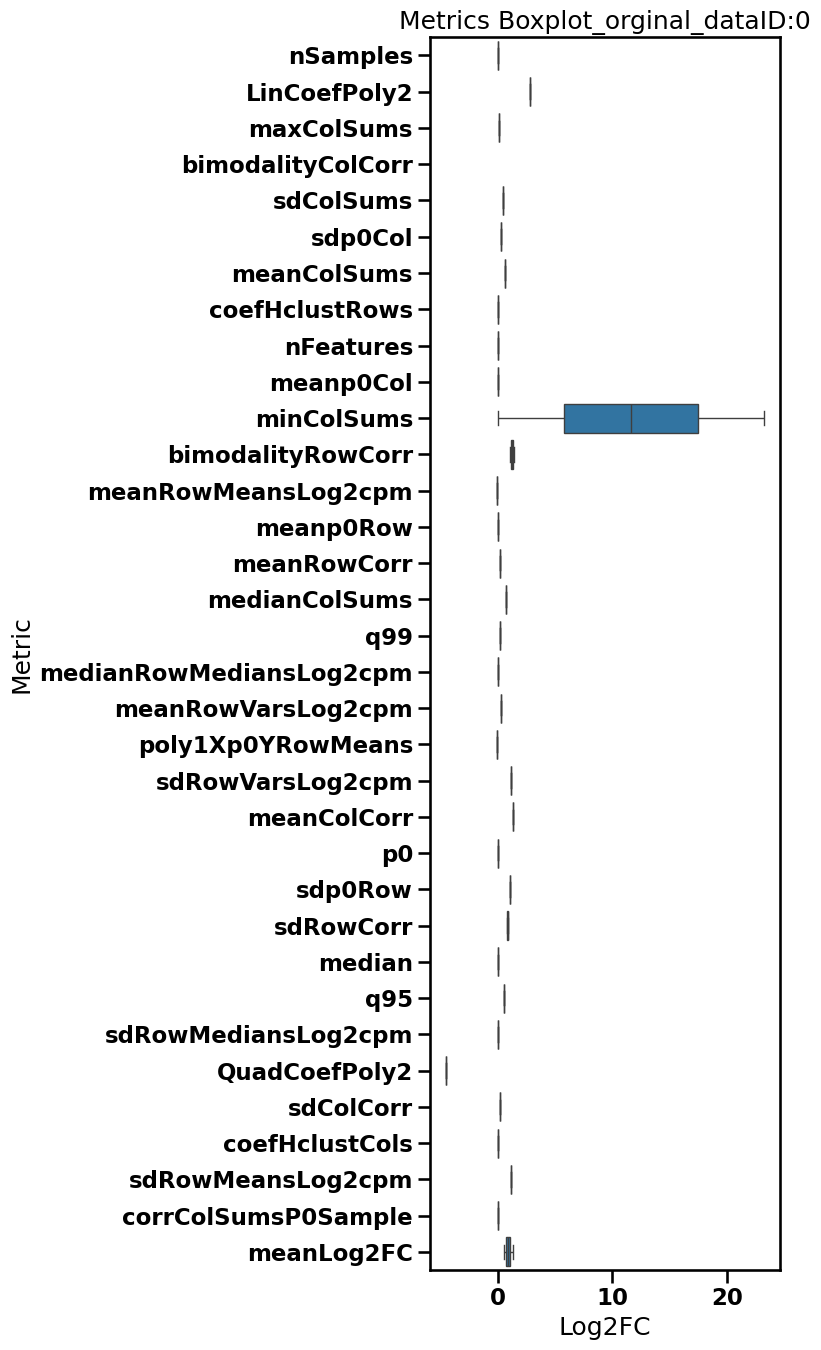

In [94]:
dp.plot_metrics()

mmcontext.eval.data_properties - WARNING - Property PCA Plot: Dropped columns with NaN values: {'bimodalityColCorr'}


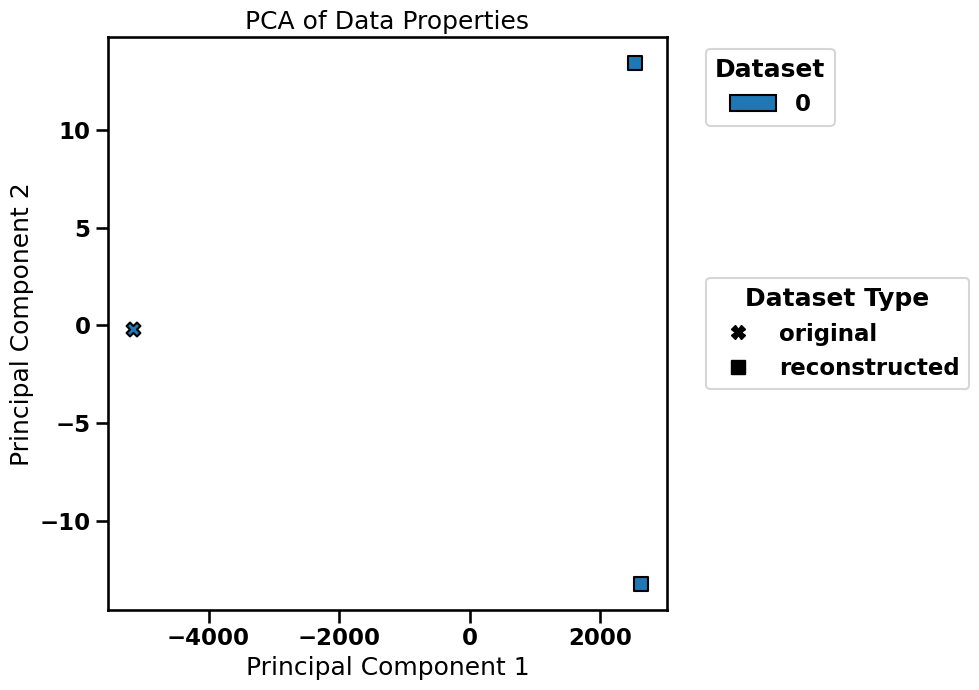

In [95]:
dp.plot_pca()